In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Opel.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Agila,Seri_Ascona,Seri_Astra,...,Model_2.5 CDX,Model_2.5 TD,Model_2.8 Sport,Model_GT 2.0 Turbo,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,448000,0.090909,-0.472222,-1.591346,-0.636704,0.0,1.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,395000,0.090909,-0.472222,-1.591346,-0.749064,5.0,4.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,579650,0.454545,-0.333333,-0.778846,-0.516854,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,243500,-1.272727,-0.333333,-0.822115,-0.167251,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,551500,0.363636,-0.750000,-1.500000,-0.621723,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_16368\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,51293.917627,1.774171e+09,42120.904069,30558.920436


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:18:10,094] A new study created in memory with name: no-name-b3aa1aff-7686-435b-a14f-0e78ae8b6c39
[I 2023-05-23 21:18:10,373] Trial 4 finished with value: 136859.32337360387 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.1286138088619018, 'max_depth': 3, 'min_child_weight': 248}. Best is trial 4 with value: 136859.32337360387.
[I 2023-05-23 21:18:10,430] Trial 6 finished with value: 81640.76925882285 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.1942275391194261, 'max_depth': 6, 'min_child_weight': 111}. Best is trial 6 with value: 81640.76925882285.
[I 2023-05-23 21:18:10,440] Trial 7 finished with value: 451653.6796177665 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.0001001901132565695, 'max_depth': 5, 'min_child_weight': 80}. Best is trial 6 with value: 81640.76925882285.
[I 2023-05-23 21:18:10,444] Trial 2 finished with value: 129972.10802579673 and parameters: {'colsa

[I 2023-05-23 21:18:12,220] Trial 30 finished with value: 185317.89861690014 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.09373365764891214, 'max_depth': 6, 'min_child_weight': 31}. Best is trial 18 with value: 45460.03868334999.
[I 2023-05-23 21:18:12,270] Trial 31 finished with value: 187611.0392892814 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.08933346370385922, 'max_depth': 6, 'min_child_weight': 91}. Best is trial 18 with value: 45460.03868334999.
[I 2023-05-23 21:18:12,360] Trial 32 finished with value: 229470.9430879105 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.06881699522452926, 'max_depth': 6, 'min_child_weight': 28}. Best is trial 18 with value: 45460.03868334999.
[I 2023-05-23 21:18:12,401] Trial 33 finished with value: 185818.40998359336 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.09040177099781324, 'max_depth': 5, 'min_child_weight':

[I 2023-05-23 21:18:14,204] Trial 62 finished with value: 64198.98799641084 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.32276957324399874, 'max_depth': 13, 'min_child_weight': 145}. Best is trial 57 with value: 45184.19320896461.
[I 2023-05-23 21:18:14,307] Trial 61 finished with value: 46297.14260298321 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.32838479076046156, 'max_depth': 13, 'min_child_weight': 3}. Best is trial 57 with value: 45184.19320896461.
[I 2023-05-23 21:18:14,318] Trial 60 finished with value: 46769.369652432906 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.32306418416293614, 'max_depth': 10, 'min_child_weight': 3}. Best is trial 57 with value: 45184.19320896461.
[I 2023-05-23 21:18:14,391] Trial 64 finished with value: 47229.84230961844 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.324331649837914, 'max_depth': 10, 'min_child_weight':

[I 2023-05-23 21:18:17,199] Trial 89 finished with value: 53976.94322955535 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.2615184030736584, 'max_depth': 13, 'min_child_weight': 11}. Best is trial 57 with value: 45184.19320896461.
[I 2023-05-23 21:18:17,222] Trial 88 finished with value: 55693.777735903066 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.2528546434750193, 'max_depth': 13, 'min_child_weight': 10}. Best is trial 57 with value: 45184.19320896461.
[I 2023-05-23 21:18:17,268] Trial 92 finished with value: 87296.24834696627 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.17013518779533918, 'max_depth': 15, 'min_child_weight': 11}. Best is trial 57 with value: 45184.19320896461.
[I 2023-05-23 21:18:17,275] Trial 93 finished with value: 82984.14640797194 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.17611119253886692, 'max_depth': 13, 'min_child_weight'

[I 2023-05-23 21:18:19,409] Trial 122 finished with value: 146067.67003551326 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1140832516387876, 'max_depth': 9, 'min_child_weight': 6}. Best is trial 57 with value: 45184.19320896461.
[I 2023-05-23 21:18:19,417] Trial 120 finished with value: 137474.53550864835 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.12125098676174968, 'max_depth': 9, 'min_child_weight': 7}. Best is trial 57 with value: 45184.19320896461.
[I 2023-05-23 21:18:19,439] Trial 121 finished with value: 141657.96416301042 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1171816369386869, 'max_depth': 9, 'min_child_weight': 7}. Best is trial 57 with value: 45184.19320896461.
[I 2023-05-23 21:18:19,482] Trial 123 finished with value: 62317.70883201599 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.21785627053285925, 'max_depth': 9, 'min_child_weight':

[I 2023-05-23 21:18:21,875] Trial 152 finished with value: 47870.75327181714 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3609506880123244, 'max_depth': 5, 'min_child_weight': 23}. Best is trial 134 with value: 45041.67823108724.
[I 2023-05-23 21:18:21,902] Trial 151 finished with value: 45448.439310965216 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3630629018901413, 'max_depth': 5, 'min_child_weight': 11}. Best is trial 134 with value: 45041.67823108724.
[I 2023-05-23 21:18:21,907] Trial 150 finished with value: 46372.803028206654 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3743384399068083, 'max_depth': 6, 'min_child_weight': 20}. Best is trial 134 with value: 45041.67823108724.
[I 2023-05-23 21:18:22,004] Trial 153 finished with value: 46265.1661399908 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.3694840014181006, 'max_depth': 6, 'min_child_weight

[I 2023-05-23 21:18:24,195] Trial 179 finished with value: 52791.40665482752 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.2589641649655092, 'max_depth': 5, 'min_child_weight': 4}. Best is trial 155 with value: 44676.049073631824.
[I 2023-05-23 21:18:24,245] Trial 181 finished with value: 53317.83245764131 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.25295085382366095, 'max_depth': 5, 'min_child_weight': 6}. Best is trial 155 with value: 44676.049073631824.
[I 2023-05-23 21:18:24,266] Trial 182 finished with value: 64327.874620263065 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.26627880882721155, 'max_depth': 5, 'min_child_weight': 105}. Best is trial 155 with value: 44676.049073631824.
[I 2023-05-23 21:18:24,703] Trial 183 finished with value: 387032.07550865295 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01593127688024124, 'max_depth': 7, 'min_child_

[I 2023-05-23 21:18:26,792] Trial 209 finished with value: 230459.31753878357 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.06827080581851432, 'max_depth': 6, 'min_child_weight': 28}. Best is trial 204 with value: 42975.36683188733.
[I 2023-05-23 21:18:26,915] Trial 211 finished with value: 440658.73465399555 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.0026323120681748936, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 204 with value: 42975.36683188733.
[I 2023-05-23 21:18:27,104] Trial 212 finished with value: 45482.94615579121 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4988331844714185, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 204 with value: 42975.36683188733.
[I 2023-05-23 21:18:27,148] Trial 213 finished with value: 425216.15974324313 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.006306158516471911, 'max_depth': 6, 'min_child_

[I 2023-05-23 21:18:29,474] Trial 239 finished with value: 45351.53997944876 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4273426383373278, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 204 with value: 42975.36683188733.
[I 2023-05-23 21:18:29,644] Trial 242 finished with value: 45132.60247180616 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4291929577769602, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 204 with value: 42975.36683188733.
[I 2023-05-23 21:18:29,715] Trial 241 finished with value: 43742.8339246763 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4382365376533449, 'max_depth': 7, 'min_child_weight': 2}. Best is trial 204 with value: 42975.36683188733.
[I 2023-05-23 21:18:29,846] Trial 244 finished with value: 44015.657820495624 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.43645305883662433, 'max_depth': 7, 'min_child_weight': 

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 42162.0072
Best params:
	colsample_bytree: 1.0
	subsample: 1.0
	learning_rate: 0.4323514237774227
	max_depth: 7
	min_child_weight: 5


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [7,10],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [1],
               'subsample': [1],
               'min_child_weight': [5]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 1}
{'TestDeger': 50788.96719763478, 'MSE': 1749270049.296549, 'RMSE': 41824.27583708472, 'MAE': 31581.298660405126}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.946530027451302

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9392320987656013

In [17]:
marka_model = joblib.dump(grid_final_model, "Opel.pkl")

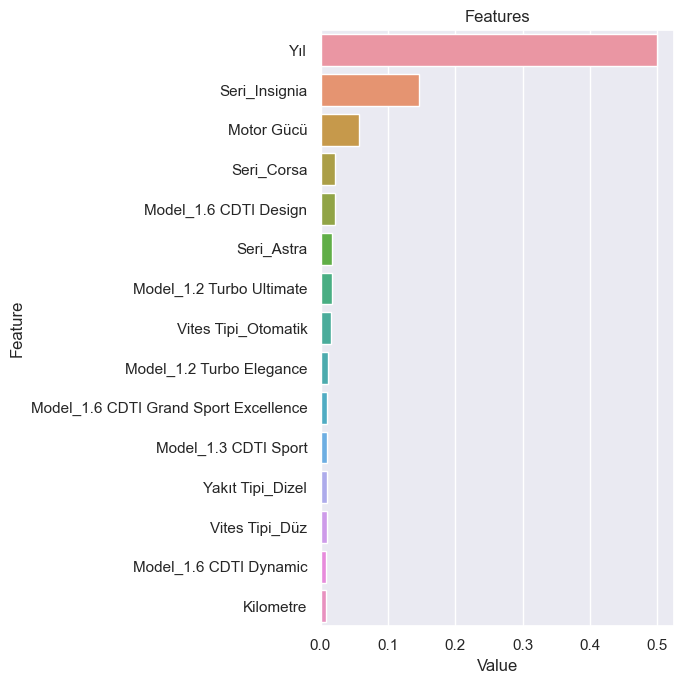

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)